### Import Libraries

In [3]:
from Feature_Engineering import feature_engineering
from businessscoring import businessgain
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import sklearn.model_selection as ms
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, recall_score, f1_score, classification_report, make_scorer
from imblearn.over_sampling import RandomOverSampler
from imblearn import over_sampling

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Pre-Processing

In [4]:
#feature engineering on full dataset
features = feature_engineering(j_flag=1)

In [5]:
#convert potential fraud values to 0 and 1
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})

In [6]:
#create variables for features and target
X = features.drop(['PotentialFraud', 'Service_Type','Provider', 'Both_Service',\
                   'Inpatient', 'Gender2', 'Race5' ], axis=1)
y = features['PotentialFraud'] 

In [7]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['Outpatient','isFraudConnected']]

#drop dummy variables
X = X.drop(['Outpatient','isFraudConnected'], axis =1)

In [8]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)

#add back dummy variables to scaled dataset 
X_scaled = pd.concat((X_scaled, non_num), axis=1)

In [9]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [10]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
#SMOTE upsampling
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

In [12]:
#random over sampling 
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

In [13]:
#business_score = make_scorer(businessgain, greater_is_better=True)

In [14]:
#create dataframe for model plot
business_scores = pd.DataFrame(columns=('Model', 'Score'))

### Logistic Regression

#### SMOTE

In [15]:
# SMOTE balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_train_Bal, y_train_Bal)
logistic.score(X_test, y_test)
print("SMOTE; \nLogistic Regression Baseline F1 score: ", f1_score(y_test,logistic.predict(X_test)))

SMOTE; 
Logistic Regression Baseline F1 score:  0.5602409638554218


In [16]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}

grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring='f1', n_jobs=-1)
%time grid_search_logit.fit(X_train_Bal, y_train_Bal)

CPU times: user 806 ms, sys: 126 ms, total: 933 ms
Wall time: 5.18 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring='f1')

In [17]:
#SMOTE
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train F1 score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set F1 score: ", f1_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
SMOTE_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 0.23684210526315788}
Logistic Regression Grid Search train F1 score:  0.8817944744164935
Logistic Best Estimator Validation set F1 score:  0.5585585585585586
Logistic Best Estimator Validation set business score:  0.7059336154387851


#### imblearn

In [18]:
# imblearn balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_ros, y_ros)
logistic.score(X_test, y_test)
print("Random oversampling; \nLogistic Regression Baseline F1 score: ", f1_score(y_test,logistic.predict(X_test)))

Random oversampling; 
Logistic Regression Baseline F1 score:  0.563467492260062


In [19]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring='f1', n_jobs=-1)
%time grid_search_logit.fit(X_ros, y_ros)

CPU times: user 666 ms, sys: 36 ms, total: 702 ms
Wall time: 3.88 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring='f1')

In [20]:
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train F1 score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set F1 score: ", f1_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
imblearn_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 1.3421052631578947}
Logistic Regression Grid Search train F1 score:  0.8661027061063995
Logistic Best Estimator Validation set F1 score:  0.5607476635514019
Logistic Best Estimator Validation set business score:  0.6520644317009321


#### Comparing SMOTE and imblearn

In [21]:
print('SMOTE logit business score: ', SMOTE_logit, '\nimblearn logit business score: ', imblearn_logit)

SMOTE logit business score:  0.7059336154387851 
imblearn logit business score:  0.6520644317009321


In [22]:
business_scores.loc[0] = 'Logistic', round(SMOTE_logit, 2)

In [23]:
confusion_matrix(y_test, logit_final.predict(X_test))

array([[851, 130],
       [ 11,  90]])

In [24]:
print(classification_report(logit_final.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       862
           1       0.89      0.41      0.56       220

    accuracy                           0.87      1082
   macro avg       0.88      0.70      0.74      1082
weighted avg       0.87      0.87      0.85      1082



#### feature importance for logistic regression

,Feature,Score
55,Outpatient,1.853643
6,Outpatient_Count,1.114500
3,Claim_Count,1.099573
48,Diagnosis_3_Count,0.974655
53,Diagnosis_8_Count,0.830431
20,ChronicCond_KidneyDisease_1,0.660344
15,Race1,0.645084
18,ChronicCond_Alzheimer_1,0.564371
50,Diagnosis_5_Count,0.551812
46,Diagnosis_1_Count,0.540093


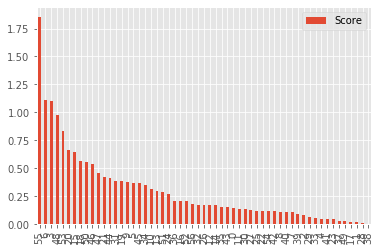

In [25]:
importance = logit_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### Stochastic Gradient Descent

#### SMOTE

In [26]:
#SMOTE
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nSGD Baseline F1 score: ", f1_score(y_test,sgd.predict(X_test)))

SMOTE: 
SGD Baseline F1 score:  0.30886850152905204


In [27]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(5e-4,1e-4,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring='f1', n_jobs=-1)
%time grid_search_sgd.fit(X_train_Bal, y_train_Bal)

CPU times: user 2.43 s, sys: 132 ms, total: 2.56 s
Wall time: 13.4 s


/Users/marcuschoi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.0005    , 0.00048621, 0.00047241, 0.00045862, 0.00044483,
       0.00043103, 0.00041724, 0.00040345, 0.00038966, 0.00037586,
       0.00036207, 0.00034828, 0.00033448, 0.00032069, 0.0003069 ,
       0.0002931 , 0.00027931, 0.00026552, 0.00025172, 0.00023793,
       0.00022414, 0.00021034, 0.00019655, 0.00018276, 0.00016897,
       0.00015517, 0.00014138, 0.00012759, 0.00011379, 0.0001    ]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring='f1')

In [28]:
print("SMOTE: \n")
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set F1 score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set F1 score: ", f1_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
SMOTE_sgd = businessgain(y_test,sgd_final.predict(X_test))

SMOTE: 

SGD Grid Search best params:  {'alpha': 0.00044482758620689657, 'max_iter': 1}
SGD Grid Search Training set F1 score:  0.8217737972906353
SGD Best Estimator Validation set F1 score:  0.33169129720853857
SGD Best Estimator Validation set business score:  0.6244233265873335


#### imblearn

In [29]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_ros, y_ros)
print("Imblearn Balanced: \nSGD Baseline F1 score: ", f1_score(y_test,sgd.predict(X_test)))

Imblearn Balanced: 
SGD Baseline F1 score:  0.30467571644042235


In [30]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(5e-4,1e-4,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring='f1', n_jobs=-1)
%time grid_search_sgd.fit(X_ros, y_ros)

CPU times: user 2.64 s, sys: 128 ms, total: 2.77 s
Wall time: 13.6 s


/Users/marcuschoi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.0005    , 0.00048621, 0.00047241, 0.00045862, 0.00044483,
       0.00043103, 0.00041724, 0.00040345, 0.00038966, 0.00037586,
       0.00036207, 0.00034828, 0.00033448, 0.00032069, 0.0003069 ,
       0.0002931 , 0.00027931, 0.00026552, 0.00025172, 0.00023793,
       0.00022414, 0.00021034, 0.00019655, 0.00018276, 0.00016897,
       0.00015517, 0.00014138, 0.00012759, 0.00011379, 0.0001    ]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring='f1')

In [31]:
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set F1 score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set F1 score: ", f1_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
imblearn_sgd = businessgain(y_test,sgd_final.predict(X_test))

SGD Grid Search best params:  {'alpha': 0.00038965517241379313, 'max_iter': 10}
SGD Grid Search Training set F1 score:  0.8242513544707799
SGD Best Estimator Validation set F1 score:  0.34246575342465757
SGD Best Estimator Validation set business score:  0.6258455810047715


#### Comparing SMOTE with imblearn

In [32]:
print('SMOTE SGD business score: ', SMOTE_sgd, '\nimblearn SGD business score: ', imblearn_sgd)

SMOTE SGD business score:  0.6244233265873335 
imblearn SGD business score:  0.6258455810047715


In [33]:
business_scores.loc[1] = 'SGD', round(SMOTE_sgd, 2)

In [34]:
confusion_matrix(y_test, sgd_final.predict(X_test))

array([[598, 383],
       [  1, 100]])

In [35]:
print(classification_report(sgd_final.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       599
           1       0.99      0.21      0.34       483

    accuracy                           0.65      1082
   macro avg       0.80      0.60      0.55      1082
weighted avg       0.78      0.65      0.57      1082



#### SGD feature Importance

,Feature,Score
55,Outpatient,18.169690
6,Outpatient_Count,11.688448
5,Inpatient_Count,10.399796
8,Norm_Outpatient_Count,9.945290
7,Norm_Inpatient_Count,9.920244
38,NetworkDegree,9.888177
46,Diagnosis_1_Count,7.944082
3,Claim_Count,7.835182
41,Procedure_1_Count,7.384267
12,Avg_Cost,6.929895


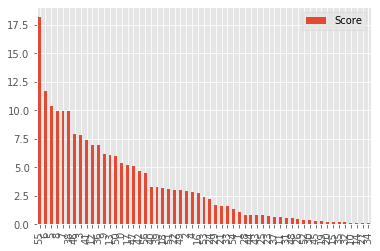

In [36]:
importance = sgd_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### K-Nearest Neighbors

#### SMOTE

In [37]:
knn = KNeighborsClassifier()
knn.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nKNN Baseline Training Set F1 score: ", f1_score(y_train_Bal,knn.predict(X_train_Bal)))
print("KNN Baseline Validation Set F1 score: ", f1_score(y_test,knn.predict(X_test)))

SMOTE: 
KNN Baseline Training Set F1 score:  0.9407942238267148
KNN Baseline Validation Set F1 score:  0.5045592705167173


In [38]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = 'f1')

knn_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring='f1', verbose=1)

In [39]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set F1 score: ", f1_score(y_train_Bal, best_knn.predict(X_train_Bal)))
print("KNN Grid Search Validation set F1 score: ", f1_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
SMOTE_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 70}
KNN Grid Search Training set F1 score:  0.8814903846153846
KNN Grid Search Validation set F1 score:  0.5000000000000001
KNN Grid Search Validation set business score:  0.6699446958734435


#### imblearn

In [40]:
knn = KNeighborsClassifier()
knn.fit(X_ros, y_ros)
print("imblearn: \nKNN Baseline Training Set F1 score: ", f1_score(y_ros,knn.predict(X_ros)))
print("KNN Baseline Validation Set F1 score: ", f1_score(y_test,knn.predict(X_test)))

imblearn: 
KNN Baseline Training Set F1 score:  0.9594032770848618
KNN Baseline Validation Set F1 score:  0.5342960288808665


In [41]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = 'f1')

knn_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring='f1', verbose=1)

In [42]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set F1 score: ", f1_score(y_ros, best_knn.predict(X_ros)))
print("KNN Grid Search Validation set F1 score: ", f1_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
imblearn_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 79}
KNN Grid Search Training set F1 score:  0.8667828685258964
KNN Grid Search Validation set F1 score:  0.5481049562682216
KNN Grid Search Validation set business score:  0.7183532531618629


#### Comparing SMOTE and imblearn

In [43]:
print('SMOTE KNN business score: ', SMOTE_knn, '\nimblearn KNN business score: ', imblearn_knn)

SMOTE KNN business score:  0.6699446958734435 
imblearn KNN business score:  0.7183532531618629


In [44]:
business_scores.loc[2] = 'KNN', round(SMOTE_knn, 2)

In [45]:
confusion_matrix(y_test, best_knn.predict(X_test))

array([[833, 148],
       [  7,  94]])

In [46]:
print(classification_report(best_knn.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       840
           1       0.93      0.39      0.55       242

    accuracy                           0.86      1082
   macro avg       0.89      0.69      0.73      1082
weighted avg       0.87      0.86      0.83      1082



### Support Vector Machine

#### SMOTE

In [47]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_Bal, y_train_Bal)

# baseline score
svm_train_f1 = f1_score(y_train_Bal, svm.predict(X_train_Bal))
svm_test_f1 = f1_score(y_test, svm.predict(X_test))

print('SMOTE: \nSVM BaseLine Train Set F1 Score:', svm_train_f1)
print('SVM BaseLine Validation Set F1 Score:', svm_test_f1)

SMOTE: 
SVM BaseLine Train Set F1 Score: 0.8812105926860027
SVM BaseLine Validation Set F1 Score: 0.5548780487804879


In [48]:
# grid search 
params = {'C': np.logspace(-1,2,10), 
          'kernel': ['linear'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = 'f1')
svm_GS.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['linear']},
             return_train_score=True, scoring='f1', verbose=1)

In [49]:
print("SVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set F1 score: ", f1_score(y_train_Bal, best_svm.predict(X_train_Bal)))
print("SVM Grid Search Validation set F1 score: ", f1_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
SMOTE_svm = businessgain(y_test, best_svm.predict(X_test))

SVM Grid Search Best params:  {'C': 46.41588833612777, 'gamma': 'auto', 'kernel': 'linear'}
SVM Grid Search Training set F1 score:  0.8744710860366712
SVM Grid Search Validation set F1 score:  0.5723270440251573
Test Set business Score: 0.6764803759457906


#### imblearn

In [50]:
svm = SVC(class_weight='balanced')
svm.fit(X_ros, y_ros)

# baseline score
svm_train_f1 = f1_score(y_ros, svm.predict(X_ros))
svm_test_f1 = f1_score(y_test, svm.predict(X_test))

print('imblearn: \nSVM BaseLine Train Set F1 Score:', svm_train_f1)
print('SVM BaseLine Validation Set F1 Score:', svm_test_f1)

imblearn: 
SVM BaseLine Train Set F1 Score: 0.8733256792958286
SVM BaseLine Validation Set F1 Score: 0.5652173913043478


In [51]:
# grid search 
params = {'C': np.logspace(-1,2,10), 
          'kernel': ['linear'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = 'f1')
svm_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/marcuschoi/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 42.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['linear']},
             return_train_score=True, scoring='f1', verbose=1)

In [52]:
print("imblearn: \nSVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set F1 score: ", f1_score(y_ros, best_svm.predict(X_ros)))
print("SVM Grid Search Validation set F1 score: ", f1_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
imblearn_svm = businessgain(y_test, best_svm.predict(X_test))

imblearn: 
SVM Grid Search Best params:  {'C': 4.6415888336127775, 'gamma': 'auto', 'kernel': 'linear'}
SVM Grid Search Training set F1 score:  0.8717684887459807
SVM Grid Search Validation set F1 score:  0.5741324921135647
Test Set business Score: 0.6774031687551583


#### Comparing SMOTE and imblearn

In [53]:
print('SMOTE SVM business score: ', SMOTE_svm, '\nimblearn SVM business score: ', imblearn_svm)

SMOTE SVM business score:  0.6764803759457906 
imblearn SVM business score:  0.6774031687551583


In [54]:
business_scores.loc[3] = 'SVM', round(SMOTE_svm, 2)

In [55]:
confusion_matrix(y_test, best_svm.predict(X_test))

array([[856, 125],
       [ 10,  91]])

In [56]:
print(classification_report(best_svm.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       866
           1       0.90      0.42      0.57       216

    accuracy                           0.88      1082
   macro avg       0.89      0.70      0.75      1082
weighted avg       0.88      0.88      0.86      1082



### Random Forest

#### SMOTE

In [57]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()

# fit RF model on SMOTE training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train_Bal, y_train_Bal)

# baseline score
print('SMOTE: \nRF BaseLine Train Set F1 Score:', f1_score(y_train_Bal, randomForest.predict(X_train_Bal)))
print('RF BaseLine Validation Set F1 Score:', f1_score(y_test, randomForest.predict(X_test)))

SMOTE: 
RF BaseLine Train Set F1 Score: 1.0
RF BaseLine Validation Set F1 Score: 0.5991561181434599


In [58]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='f1', cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_train_Bal, y_train_Bal)

CPU times: user 8.11 s, sys: 585 ms, total: 8.7 s
Wall time: 4min 55s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring='f1')

In [59]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set F1 score: ", f1_score(y_train_Bal, best_RF.predict(X_train_Bal)))
print("RF Grid Search Validation set F1 score: ", f1_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
SMOTE_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 24, 'n_estimators': 80}
RF Grid Search Training set F1 score:  1.0
RF Grid Search Validation set F1 score:  0.6026200873362445
RF Grid Search Validation set Business score:  0.2823624880109028


#### imblearn

In [60]:
randomForest.set_params(random_state=0)

randomForest.fit(X_ros, y_ros)

# baseline score
print('imblearn: \nRF BaseLine Train Set F1 Score:', f1_score(y_ros, randomForest.predict(X_ros)))
print('RF BaseLine Validation Set F1 Score:', f1_score(y_test, randomForest.predict(X_test)))

imblearn: 
RF BaseLine Train Set F1 Score: 1.0
RF BaseLine Validation Set F1 Score: 0.6632124352331605


In [61]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='f1', cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_ros, y_ros)

CPU times: user 6.25 s, sys: 392 ms, total: 6.64 s
Wall time: 2min 45s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring='f1')

In [62]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set F1 score: ", f1_score(y_ros, best_RF.predict(X_ros)))
print("RF Grid Search Validation set F1 score: ", f1_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
imblearn_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 28, 'n_estimators': 20}
RF Grid Search Training set F1 score:  1.0
RF Grid Search Validation set F1 score:  0.6358974358974359
RF Grid Search Validation set Business score:  0.1622044828121188


#### comparing SMOTE and imblearn

In [63]:
print('SMOTE RF business score: ', SMOTE_rf, '\nimblearn RF business score: ', imblearn_rf)

SMOTE RF business score:  0.2823624880109028 
imblearn RF business score:  0.1622044828121188


In [64]:
business_scores.loc[4] = 'RF', round(SMOTE_rf, 2)

In [65]:
confusion_matrix(y_test, best_RF.predict(X_test))

array([[949,  32],
       [ 39,  62]])

In [66]:
print(classification_report(best_RF.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       988
           1       0.61      0.66      0.64        94

    accuracy                           0.93      1082
   macro avg       0.79      0.81      0.80      1082
weighted avg       0.94      0.93      0.94      1082



### XGBOOST

#### SMOTE

In [67]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_Bal, y_train_Bal)

print('SMOTE: \nXGB BaseLine Train Set F1 Score:', f1_score(y_train_Bal, xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set F1 Score:', f1_score(y_test, xgb.predict(X_test)))

SMOTE: 
XGB BaseLine Train Set F1 Score: 0.9998725302740599
XGB BaseLine Validation Set F1 Score: 0.6138613861386139


In [68]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [400,500,600],
                 'learning_rate': [0.001, 0.010, 0.1],
                 'n_estimators': [2,5,10] ,
                 'max_depth': [1,3,10],
                 'subsample': [0.9]
                 } 

grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring='f1', cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_train_Bal, y_train_Bal)

CPU times: user 3.21 s, sys: 158 ms, total: 3.37 s
Wall time: 15.7 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...ints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     

In [69]:
print("XGB Grid Search Best params: ", grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set F1 Score:', f1_score(y_train_Bal, best_xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set F1 Score:', f1_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
SMOTE_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB Grid Search Best params:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 10, 'scale_pos_weight': 400, 'subsample': 0.9}
XGB BaseLine Train Set F1 Score: 0.8056268610740323
XGB BaseLine Validation Set F1 Score: 0.29596412556053814
XGB BaseLine Validation Set business Score: 0.5257606263917589


#### imblearn

In [70]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_ros, y_ros)
print('imblearn: \nXGB BaseLine Train Set F1 Score:', f1_score(y_ros, xgb.predict(X_ros)))
print('XGB BaseLine Validation Set F1 Score:', f1_score(y_test, xgb.predict(X_test)))

imblearn: 
XGB BaseLine Train Set F1 Score: 1.0
XGB BaseLine Validation Set F1 Score: 0.6220095693779905


In [71]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [400,500,600],
                 'learning_rate': [0.001, 0.010, 0.1],
                 'n_estimators': [2,5,10] ,
                 'max_depth': [1,3,10],
                 'subsample': [0.9]
                 }
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring='f1', cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_ros, y_ros)

CPU times: user 2.37 s, sys: 109 ms, total: 2.48 s
Wall time: 12 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...ints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     

In [72]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set F1 Score:', f1_score(y_ros, best_xgb.predict(X_ros)))
print('XGB BaseLine Validation Set F1 Score:', f1_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
imblearn_xgb = f1_score(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set F1 Score: 0.8177175612298072
XGB BaseLine Validation Set F1 Score: 0.31578947368421056
XGB BaseLine Validation Set business Score: 0.5645179243852037


#### comparing SMOTE and imblearn

In [73]:
print('SMOTE XGB business score: ', SMOTE_xgb, '\nimblearn XGB business score: ', imblearn_xgb)

SMOTE XGB business score:  0.5257606263917589 
imblearn XGB business score:  0.31578947368421056


In [74]:
business_scores.loc[5] = 'XGBoost', round(SMOTE_xgb, 2)

In [75]:
confusion_matrix(y_test, best_xgb.predict(X_test))

array([[554, 427],
       [  2,  99]])

In [76]:
print(classification_report(best_xgb.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72       556
           1       0.98      0.19      0.32       526

    accuracy                           0.60      1082
   macro avg       0.77      0.59      0.52      1082
weighted avg       0.77      0.60      0.52      1082



### Business Gain Plot

,Model,Score
0,Logistic,0.71
1,SGD,0.62
2,KNN,0.67
3,SVM,0.68
4,RF,0.28
5,XGBoost,0.53


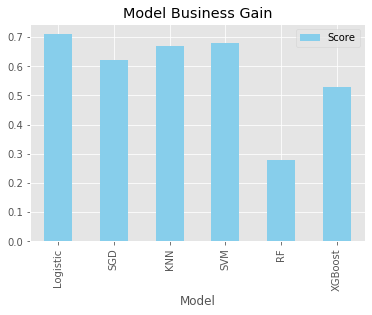

In [77]:
business_scores.plot.bar(x = 'Model', color = 'skyblue')
plt.title('Model Business Gain')
business_scores